In [12]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import scipy.interpolate as sciint

# Time synchronous averaging example

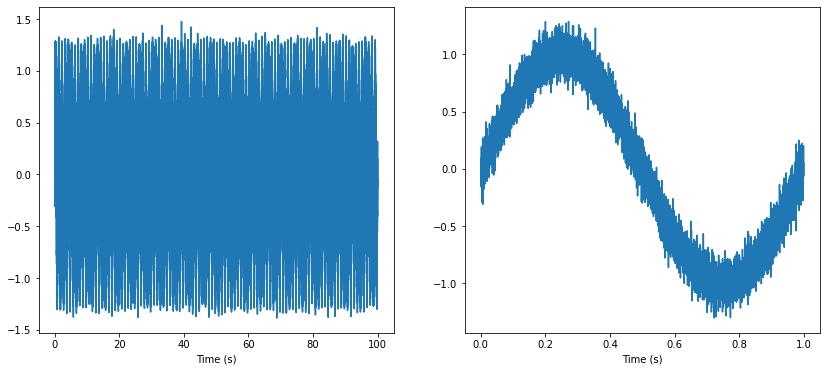

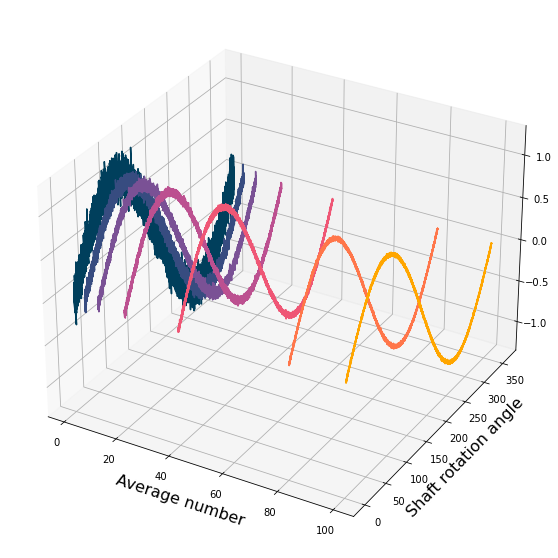

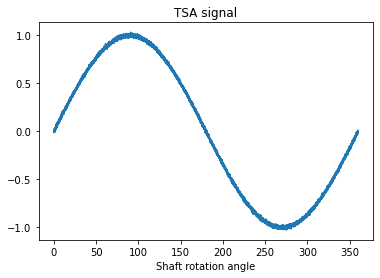

In [13]:
%matplotlib inline
Fs = 10000
t = np.arange(0, 100, 1/Fs)
Fshaft = 10

signal = np.sin(1 * 2 * np.pi * t) + 0.1 * np.random.randn(len(t))

fig, ax = plt.subplots(1, 2, figsize = (14, 6))
ax = ax.flatten()

ax[0].plot(t, signal)
ax[1].plot(t[:Fs], signal[:Fs])

for axs in ax:
    axs.set_xlabel("Time (s)")
plt.show()

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection = '3d')

avg = np.zeros(Fs)
cnt = 0
cnt_3d = 0
colors = ["#003f5c", "#374c80", "#7a5195", "#bc5090", "#ef5675", "#ff764a", "#ffa600"]
for i in range(0, len(t), Fs):
    avg += signal[i:i + Fs]
    cnt += 1
    
    if cnt in [1, 5, 10, 20, 40, 80, 100]:
        ax.plot([cnt] * Fs, np.linspace(0, 360, Fs), avg / cnt, color = colors[cnt_3d])
        cnt_3d += 1

ax.set_xlabel("Average number", fontsize = 16)
ax.set_ylabel("Shaft rotation angle", fontsize = 16)
plt.show()

avg /= cnt
rot = np.linspace(0, 360, Fs)

plt.figure()
plt.title("TSA signal")
plt.plot(rot, avg)
plt.xlabel("Shaft rotation angle")
plt.show()


# Computed Order Tracking example

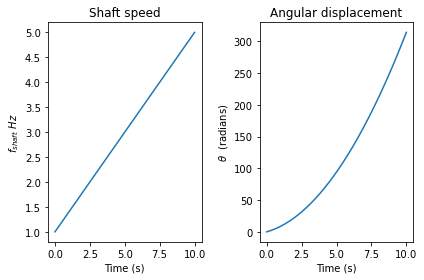

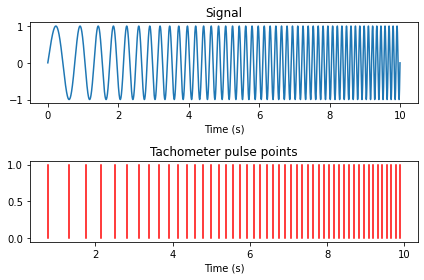

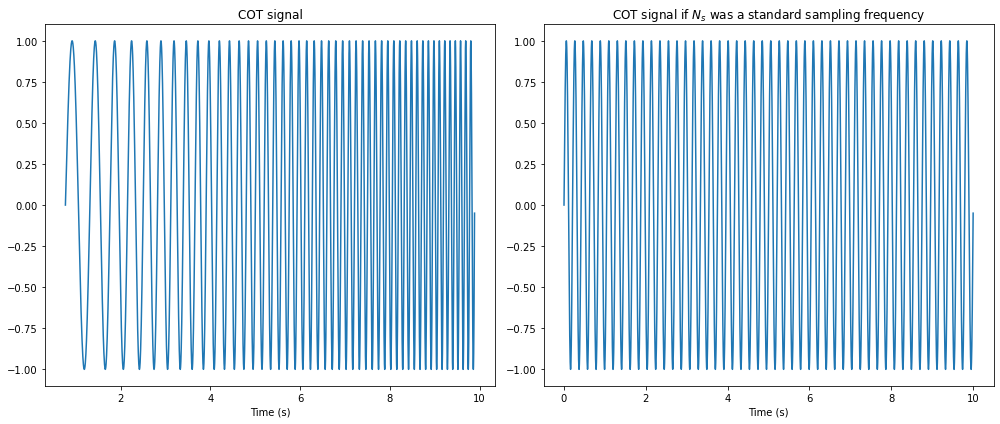

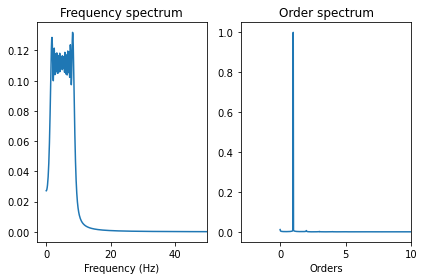

In [16]:
%matplotlib inline
F0 = 1 #Hz
F1 = 5 #Hz

t0 = 0
t1 = 10
Fs = 50000

t = np.arange(t0, t1, 1/Fs)
f_shaft = F0 + (F1 - F0) * t / t1 #np.linspace(F0, F1, len(t)) 
omega = f_shaft * 2 * np.pi
theta = omega * t

signal = np.sin(omega * t)

fig, ax = plt.subplots(1, 2)
ax[0].set_title("Shaft speed")
ax[0].plot(t, omega / (2 * np.pi))
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel(r"$f_{shaft}$ $Hz$")

ax[1].set_title("Angular displacement")
ax[1].plot(t, theta)
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel(r"$\theta$  (radians)")
fig.tight_layout()
plt.show()

Nr = 0
pos = []

#Obtain rotation indices
for cnt, i in enumerate(theta):
    i = i - Nr * 2 * np.pi
    if i >= 2 * np.pi:
        Nr += 1
        pos.append(cnt)

fig, ax = plt.subplots(2, 1)
ax[0].set_title("Signal")
ax[0].plot(t, signal)
ax[0].set_xlabel("Time (s)")

for i in pos:
    ax[1].plot([t[i]] * 2, [0, 1], "r-")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Tachometer pulse points")
fig.tight_layout()
plt.show()

COT_signal = []
COT_time = []
Ns =  128 #Number of orders

signal_interp = sciint.interp1d(t, signal)

for i in range(len(pos) - 1):
    start_pos = pos[i]
    end_pos = pos[i + 1]
    
    dt = t[end_pos] - t[start_pos]
    time_interpolate = np.arange(t[start_pos], t[end_pos], dt / Ns)
    #Alternatively: np.linspace(t[start_pos], t[end_pos], Ns, endpoint = False)
    
    #Peform interpolation
    #Method 1
    interpolated_signal = signal_interp(time_interpolate)
    
    #method 2
    #interpolated_signal = np.interp(time_interpolate, t, signal) #(hint, hint:how does np.interp work?)
    
    #Method 3
    #sig_rotation = signal[start_pos:end_pos] #legacy code
    #interpolated_signal = np.interp(time_interpolate, t[start_pos:end_pos], sig_rotation) #(hint, hint:how does np.interp work?)
    
    COT_signal.append(interpolated_signal)
    COT_time.append(time_interpolate)

COT_signal = np.array(COT_signal).reshape(-1) #Reshape to correct size (hint, hint: can we get the TSA signal by changing this line a little?)
COT_time = np.array(COT_time).reshape(-1)

fig, ax = plt.subplots(1, 2, figsize = (14, 6))
ax = ax.flatten()
ax[0].set_title("COT signal")
ax[0].plot(COT_time, COT_signal)

ax[1].set_title(r"COT signal if $N_s$ was a standard sampling frequency")
ax[1].plot(np.linspace(t0, t1, len(COT_signal)), COT_signal)

for i in ax:
    i.set_xlabel("Time (s)")

fig.tight_layout()
plt.show()


n_orig = len(signal)
fft_freq_orig = np.fft.fftfreq(n_orig, 1/Fs)[0:n_orig // 2]
fft_vals_orig = 2 /n_orig * np.abs(np.fft.fft(signal)[0:n_orig // 2])

n_COT = len(COT_signal) #Should be Nr * Ns
fft_freq_COT = np.fft.fftfreq(n_COT, 1/Ns)[0:n_COT // 2]
fft_vals_COT = 2 /n_COT * np.abs(np.fft.fft(COT_signal)[0:n_COT // 2])

fig, ax = plt.subplots(1, 2)
ax[0].plot(fft_freq_orig, fft_vals_orig)
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_title("Frequency spectrum")
ax[0].axis([-3, 50, None, None])

ax[1].plot(fft_freq_COT, fft_vals_COT)
ax[1].set_xlabel("Orders")
ax[1].set_title("Order spectrum")
ax[1].axis([-3, 10, None, None])
fig.tight_layout()
plt.show()